# Map Data

This project aligns readings from an ATV-based sampling system to a custom map grid and then aggregates the readings within those grid cells and subcells based on the assumptions below. The purpose of this aggregation is to generalize the reading levels across the geographic region.

* Input data is in a CSV file formatted y, x, reading
* Coordinates (y,x) are in local project format using US survey feet
* Map Tiles are named using two letters starting in the lower-left corner of the region as AA (first letter is vertical, second letter is horizontal)
* Each Tile is subdivided into 378 Survey Units (su) arranged 21 cells horizontally and 18 cells vertically
* The Survey Units are numbered 1 to 378 starting in the upper-left corner of the cell and proceeding left-to-right and top-to-bottom
* Each Survey Unit is 10m x 10m in size
* Each Survey Unit should be further divided into Subcells that are 1m x 1m
* For reference, the lower-left (South West) corner of Tile AA is (E): 2180160.0001Y (N): 6660000.0000
* For reference, each Survey Unit is 32.81 ft x 32.81 ft
* The map area goes from AA to OL (12 horizontal Tiles X 15 vertical Tiles)


In [1]:
import logging
from PIL import Image, ImageDraw, ImageColor
logger = logging.getLogger()

## 1. Convert (x, y) to (Tile, SU, Subcell)
The function here is used to convert the given x and y coordinates to the correspoding Tile, Survey Unit, and Subcell. The origin, SU size, and grid dimensions are all customizable, but the values used in the Moab project are provided as defaults.

In [2]:
def convert_xy(x, y, 
    units="usft", 
    origin=(2180160.0001, 6660000.0000),
    su_size=32.81,
    tile_grid=(21, 18),
    subcell_grid=10):
    """
    x: Local coordinate Easting in given units
    y: Local coordinate Northing in given units
    origin: (x,y) of the bottom left corner
    su_size: horizontal and vertical size of an SU in given units
    tile_grid: dimensions of an Tile as (width in SUs, height in SUs)
    subcell_grid: number of subcells to divide each SU into horizontally and vertically

    Converts from Local coordinate format into Tile, SU, Subcell. 
    2180160.0001, 6660000.0000 -> ("AA", 358, 91)

    >>> convert_xy(2180160.0001, 6660000.0000)  
    ('AA', 358, 1)

    >>> convert_xy(2180160.0001 + 32.81*21.01, 6660000.0000)
    ('AB', 358, 1)

    >>> convert_xy(2180160.0001 + 32.81*22.01 + 4, 6660000.0000 + 32.81*19.01 + 4)
    ('BB', 338, 12)
    """
    # TODO: Probably worth adding a bunch more test cases using other parameters
    #       to make sure all the calculations work properly.

    origin_x = origin[0]
    origin_y = origin[1]
    tile_grid_x = tile_grid[0]
    tile_grid_y = tile_grid[1]
    subcell_size = su_size / subcell_grid

    # 1. How many feet away from the origin are we and how many Tiles is that?
    tile_x_n = (x - origin_x) // (tile_grid_x * su_size)
    tile_y_n = (y - origin_y) // (tile_grid_y * su_size)
    tile_x_c = chr(int(65 + tile_x_n))
    tile_y_c = chr(int(65 + tile_y_n))
    tile = tile_y_c + tile_x_c

    logging.debug(f'{x}, {y} is {tile_x_n} Tiles right and {tile_y_n} Tiles up from the origin of AA')

    # 2a. Compute the origin of the Tile and figure out which SU we're in
    tile_origin_x = origin_x + (tile_x_n * tile_grid_x * su_size)
    tile_origin_y = origin_y + (tile_y_n * tile_grid_y * su_size)
    logging.debug(f'The origin of Tile {tile} is {tile_origin_x}, {tile_origin_y}')

    # 2b. Compute how many SUs we are from the origin of the Tile we're in
    su_x_n = (x - tile_origin_x) // su_size
    su_y_n = (y - tile_origin_y) // su_size
    logging.debug(f'{x}, {y} is {su_x_n} SUs right and {su_y_n} Sus up from the origin of {tile}')

    # SU = bottom left SU + SUs right - SU rows up
    # SUs start in the top left corner and progress left-to-right and top-to-bottom
    su = int((tile_grid_x * (tile_grid_y - 1) + 1) + (su_x_n) - (tile_grid_x * su_y_n))

    # 3a. Compute the origin of the SU and figure out which Subcell we're in
    su_origin_x = tile_origin_x + (su_x_n * su_size)
    su_origin_y = tile_origin_y + (su_y_n * su_size)
    logging.debug(f'The origin of SU {tile}-{su} is {su_origin_x}, {su_origin_y}')

    # 3b. Compute how many Subcells we are from the origin of the SU we're in
    subcell_x_n = (x - su_origin_x) // subcell_size
    subcell_y_n = (y - su_origin_y) // subcell_size
    logging.debug(f'{x}, {y} is {subcell_x_n} subcells right and {subcell_y_n} subcells up from the origin of {tile}-{su}')
    
    # subcell = bottom left subcell + subcells right + subcells rows up
    # subcells start in the bottom left corner and progress left-to-right and bottom-to-top
    subcell = int(1 + (subcell_x_n) + (subcell_grid * subcell_y_n))

    return (tile, su, subcell)


In [3]:
# Turn on debugging and run a test to make sure things are working in a way that makes sense.
logger.setLevel(level=logging.DEBUG)

# x = origin + 22 Cells + 4 feet
# y = origin + 19 Cells + 4 feet
convert_xy(2180160.0001 + 32.81*22.01 + 4, 6660000.0000 + 32.81*19.01 + 4)

DEBUG:root:2180886.1481999997, 6660627.7181 is 1.0 Tiles right and 1.0 Tiles up from the origin of AA
DEBUG:root:The origin of Tile BB is 2180849.0100999996, 6660590.58
DEBUG:root:2180886.1481999997, 6660627.7181 is 1.0 SUs right and 1.0 Sus up from the origin of BB
DEBUG:root:The origin of SU BB-338 is 2180881.8200999997, 6660623.39
DEBUG:root:2180886.1481999997, 6660627.7181 is 1.0 subcells right and 1.0 subcells up from the origin of BB-338


('BB', 338, 12)

## 2. Read in a whole file of points with readings and convert those to grid locations
This section is where we read in an entire input file (using Pandas) and do our two different aggregation styles.
1. Arithmetic Mean in each Subcell -> Arithmetic Mean at the SU level
2. Arithmetic Mean of all the points in each SU

We also compute the difference between these aggregation styles to show how much error can be introduced. The "base" we compare against is #3 above, the "average of averages" calculation using arithmetic means.

In [4]:
# Use Pandas to read in the file and set the column headers since they aren't included
import pandas as pd

# Specify the file names and locations here
INPUT_FILE='SDG-001_Ra226_ScanData_YXReading.csv'
OUTPUT_FILE='SDG-001_Ra226_ScanData_YXReading.xlsx'

points = pd.read_csv(INPUT_FILE, dtype=float, header=None)
points.columns = ['Northing','Easting','Reading']
points.head()

,Northing,Easting,Reading
0,6666833.677,2187712.959,0.27809
1,6666833.668,2187712.959,0.33535
2,6666833.678,2187712.954,0.47949
3,6666833.672,2187712.957,1.10190
4,6666833.682,2187712.958,1.11176


In [5]:
# Change the logging level so we don't get lots of noise from the convert_xy() function.
logger.setLevel(level=logging.INFO)

points[['Tile','SU','Subcell']] = points.apply(lambda v: convert_xy(v[1], v[0]), axis=1, result_type='expand')
points.head()

/var/folders/_b/_j786t1s5zl7bhd_071450w80000gn/T/ipykernel_64609/466851825.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  points[['Tile','SU','Subcell']] = points.apply(lambda v: convert_xy(v[1], v[0]), axis=1, result_type='expand')


,Northing,Easting,Reading,Tile,SU,Subcell
0,6666833.677,2187712.959,0.27809,LK,168,23
1,6666833.668,2187712.959,0.33535,LK,168,23
2,6666833.678,2187712.954,0.47949,LK,168,23
3,6666833.672,2187712.957,1.10190,LK,168,23
4,6666833.682,2187712.958,1.11176,LK,168,23


## Do a multi-level aggregation of the readings within the grid locations

* Arithmetic Mean of the mean of all Subcells within an SU
* Arithmetic Mean of all the individual readings in an SU


In [6]:
# Compute the arithmetic and geometric means at the subcell level
from scipy.stats import gmean

subcell_mean = points.groupby(['Tile','SU','Subcell']).agg({'Reading': ['mean', 'count']}).reset_index()
subcell_mean.columns = ['Tile','SU','Subcell','Reading_mean', 'Reading_count']
subcell_mean

,Tile,SU,Subcell,Reading_mean,Reading_count
0,LH,104,8,4.958390,1
1,LH,104,10,11.788690,2
2,LH,104,20,8.212020,1
3,LH,104,28,2.421935,2
4,LH,104,30,2.429155,2
...,...,...,...,...,...
33684,ML,364,94,1.135020,1
33685,ML,364,96,2.366960,1
33686,ML,364,97,0.937815,2
33687,ML,364,99,1.299360,3


In [7]:
# Compute the arithmetic average of the subcell averages
su_subcell_mean = subcell_mean.groupby(['Tile','SU']).agg({'Reading_mean': ['mean', 'count'], 'Reading_count': 'sum'}).reset_index()
su_subcell_mean.columns = ['Tile','SU','Subcell_mean','Subcell_count','Reading_count']
su_subcell_mean

,Tile,SU,Subcell_mean,Subcell_count,Reading_count
0,LH,104,3.430701,13,107
1,LH,105,3.092665,46,61
2,LH,125,25.424101,10,14
3,LH,126,16.815088,43,110
4,LH,147,1.209051,15,16
...,...,...,...,...,...
814,ML,360,1.159399,75,229
815,ML,361,1.629131,73,122
816,ML,362,1.506259,59,75
817,ML,363,1.212841,58,74


In [8]:
# Compute the average in each cell based on all the points in that cell
su_mean = points.groupby(['Tile', 'SU']).agg({'Reading': ['mean', 'count']}).reset_index()
su_mean.columns = ['Tile','SU','Point_mean','Point_count']
su_mean.head()

,Tile,SU,Point_mean,Point_count
0,LH,104,1.696908,107
1,LH,105,2.868267,61
2,LH,125,24.996896,14
3,LH,126,14.201458,110
4,LH,147,1.215186,16


In [9]:
# Compute the percent difference between the subcell-based mean and the point-based mean
sus = pd.merge(su_subcell_mean, su_mean, how='outer', on=['Tile','SU'])
sus['Point_diff'] = (sus['Point_mean'] - sus['Subcell_mean']) / sus['Subcell_mean']
sus

,Tile,SU,Subcell_mean,Subcell_count,Reading_count,Point_mean,Point_count,Point_diff
0,LH,104,3.430701,13,107,1.696908,107,-0.505376
1,LH,105,3.092665,46,61,2.868267,61,-0.072558
2,LH,125,25.424101,10,14,24.996896,14,-0.016803
3,LH,126,16.815088,43,110,14.201458,110,-0.155434
4,LH,147,1.209051,15,16,1.215186,16,0.005074
...,...,...,...,...,...,...,...,...
814,ML,360,1.159399,75,229,1.080885,229,-0.067719
815,ML,361,1.629131,73,122,1.590442,122,-0.023749
816,ML,362,1.506259,59,75,1.525121,75,0.012522
817,ML,363,1.212841,58,74,1.203128,74,-0.008009


In [10]:
# Create a glossary or table of contents page to include in the output Excel file
glossary = pd.DataFrame([
    ['Points', 'This sheet contains the raw data points with the Tile, SU, and Subcell location appended to each row'],
    ['Subcells', 'This sheet contains multiple aggregates at the Subcell level: arithmetic mean, count of readings'],
    ['SurveyUnits', 'This sheet contains multiple aggregates at the SU level: arithmetic mean of the subcell arithmetic means, arithmetic mean of all points in that SU, count of subcells with data, count of readings'],
])

In [11]:
# Write four sheets out to an Excel file
with pd.ExcelWriter(OUTPUT_FILE) as writer:
    glossary.to_excel(writer, sheet_name='Glossary', header=False)
    points.to_excel(writer, sheet_name='Points')
    subcell_mean.to_excel(writer, sheet_name='Subcells')
    sus.to_excel(writer, sheet_name='SurveyUnits')


<Axes: >

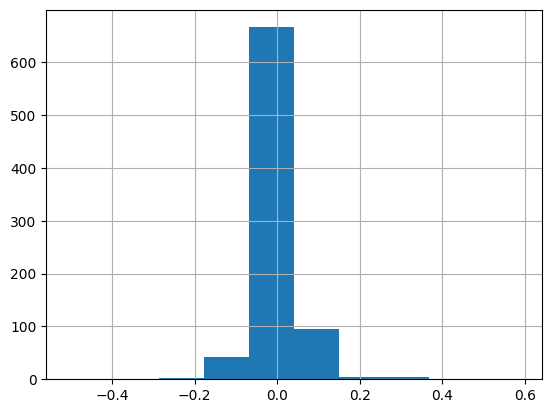

In [12]:
# For the sake of seeing the range and distribution of how much error is caused by
# not doing the average of averages method, we can include a histogram.

sus['Point_diff'].hist()

## 3. Plot a grid with points on it as a demonstration
To help us be sure we're calculating the grid locations correctly, I wrote a plotting function to draw out the grid and apply a color scheme to the SUs or Subcells we've computed values for.  This function is less well tested and documented, but you can see how it works below.

In [13]:
def plot(xs=[], ys=[], colors=[], shadings={},
    units="usft", 
    origin=(2180160.0001, 6660000.0000),
    su_size=32.81,
    tile_grid=(21, 18),
    subcell_grid=10,
    subcell_size_px=50,
    base_su=(1, 1),
    height_tiles=3,
    width_tiles=3,
    subcell_text=False,
    su_text=False,
    tile_text=False,
    level_colors=('red','blue','gray')):
    """
    xs, ys, colors: points to plot with a small dot
    shadings: dictionary of shading color keyed on subcell or cell

    Plots the appropriate grid and a series of given points in that grid
    """

    tile_grid_x = tile_grid[0]
    tile_grid_y = tile_grid[1]

    su_size_px = subcell_size_px * subcell_grid
    tile_size_x_px = tile_grid_x * su_size_px
    tile_size_y_px = tile_grid_y * su_size_px

    width_px = width_tiles * tile_grid_x * subcell_grid * subcell_size_px
    height_px = height_tiles * tile_grid_y * subcell_grid * subcell_size_px

    img = Image.new("RGBA", (width_px, height_px), "white")
    draw = ImageDraw.Draw(img)
    grid = {}

    # draw the subcell, cell, su grid
    # And build our array of subcell coordinates
    for tx in range(width_tiles):
        for ty in range(height_tiles):
            tile_x = tx * tile_size_x_px
            tile_y = ty * tile_size_y_px
            tile_x_n = base_su[0]-1 + tx
            tile_y_n = base_su[1]-1 + height_tiles - ty - 1
            tile_x_c = chr(65+tile_x_n)
            tile_y_c = chr(65+tile_y_n)
            tile = tile_y_c + tile_x_c
            tile_box = [tile_x, tile_y, (tx+1) * tile_size_x_px, (ty+1) * tile_size_y_px]

            logging.info(f"Drawing Tile: {tile} at {tile_box}")
            draw.rectangle(tile_box, None, level_colors[0], 5)

            su_num = 1
            for sy in range(tile_grid_y):
                for sx in range(tile_grid_x):
                    su_x = tile_x + (sx * su_size_px)
                    su_y = tile_y + (sy * su_size_px)
                    su_box = [su_x, su_y, su_x + su_size_px, su_y + su_size_px]
                    # logging.debug(f"Drawing SU: {tile}-{su} at {su_box}")
                    if (tile, su_num) in shadings:
                        su_color = shadings.get((tile, su_num))
                    elif tile+'-'+str(su_num) in shadings:
                        su_color = shadings.get(tile+'-'+str(su_num))
                    else:
                        su_color = None
                    draw.rectangle(su_box, su_color, level_colors[1], 3)
                    if su_text:
                        draw.text([su_x + su_size_px/2, su_y + su_size_px/2], 
                                f'{tile}-{su_num}', level_colors[1],
                                anchor='mm', font_size=2*subcell_size_px)

                    subcell = 1
                    for by in range(subcell_grid, 0, -1):
                        for bx in range(subcell_grid):
                            subcell_x = su_x + (bx * subcell_size_px)
                            subcell_y = su_y + ((by-1) * subcell_size_px)
                            subcell_box = [subcell_x, subcell_y, subcell_x + subcell_size_px, subcell_y + subcell_size_px]
                            # logging.debug(f"Drawing Subcell: {tile}-{su}-{subcell} at {subcell_box}")
                            if (tile, su_num, subcell) in shadings:
                                subcell_color = shadings.get((tile, su_num, subcell))
                            elif tile+'-'+str(su_num)+'-'+str(subcell) in shadings:
                                subcell_color = shadings.get(tile+'-'+str(su_num)+'-'+str(subcell))
                            else:
                                subcell_color = None
                            draw.rectangle(subcell_box, subcell_color, level_colors[2], 1)
                            if subcell_text:
                                draw.text([subcell_x + subcell_size_px/2, subcell_y + subcell_size_px/2], 
                                        f'{tile}-{su_num}-{subcell}', level_colors[2],
                                        anchor='mm', font_size=subcell_size_px/5)

                            # Store the subcell coordinates
                            grid[(tile, su_num, subcell)] = subcell_box
                            subcell += 1

                    # Store the SU coordinates
                    grid[(tile, su_num)] = su_box
                    su_num += 1

            # Store the Tile coordinates
            grid[(tile)] = tile_box

            if tile_text:
                draw.text([tile_x + tile_size_x_px/2, tile_y + tile_size_y_px/2], 
                        f'{tile}', level_colors[0],
                        anchor='mm', font_size=20*subcell_size_px)


    # Now plot our points
    for in_x, in_y, color in zip(xs, ys, colors):
        # Distance from origin in given units
        # TODO: Take into account that we've shifted up/over some number of tiles
        base_x = in_x - origin[0]
        base_y = in_y - origin[1]

        # Size of a pixel in given units
        unit_per_px = su_size / subcell_grid / subcell_size_px
        base_x_px = base_x / unit_per_px
        base_y_px = base_y / unit_per_px

        # Reset coordinate system
        x_coord = base_x_px
        y_coord = height_px - base_y_px

        # Location info
        loc = convert_xy(in_x, in_y)
        logging.debug(f"Drawing point {in_x}, {in_y} in {loc} at {x_coord}, {y_coord}")
        draw.circle([x_coord, y_coord], 10, color)


    return (img, grid)

In [15]:
sus

,Tile,SU,Subcell_mean,Subcell_count,Reading_count,Point_mean,Point_count,Point_diff
0,LH,104,3.430701,13,107,1.696908,107,-0.505376
1,LH,105,3.092665,46,61,2.868267,61,-0.072558
2,LH,125,25.424101,10,14,24.996896,14,-0.016803
3,LH,126,16.815088,43,110,14.201458,110,-0.155434
4,LH,147,1.209051,15,16,1.215186,16,0.005074
...,...,...,...,...,...,...,...,...
814,ML,360,1.159399,75,229,1.080885,229,-0.067719
815,ML,361,1.629131,73,122,1.590442,122,-0.023749
816,ML,362,1.506259,59,75,1.525121,75,0.012522
817,ML,363,1.212841,58,74,1.203128,74,-0.008009


## 4. Draw LH to ML with coloring

In [18]:
def color_map(x):
    if x < 5:
        return '#0000ff33'
    elif x < 7.4:
        return '#8800dd99'
    else:
        return '#ff0055bb'
    
sus['color'] = sus['Subcell_mean'].apply(color_map)
sus['location'] = sus['Tile'] + '-' + sus['SU'].astype(str)
sus

,Tile,SU,Subcell_mean,Subcell_count,Reading_count,Point_mean,Point_count,Point_diff,color,location
0,LH,104,3.430701,13,107,1.696908,107,-0.505376,#0000ff33,LH-104
1,LH,105,3.092665,46,61,2.868267,61,-0.072558,#0000ff33,LH-105
2,LH,125,25.424101,10,14,24.996896,14,-0.016803,#ff0055bb,LH-125
3,LH,126,16.815088,43,110,14.201458,110,-0.155434,#ff0055bb,LH-126
4,LH,147,1.209051,15,16,1.215186,16,0.005074,#0000ff33,LH-147
...,...,...,...,...,...,...,...,...,...,...
814,ML,360,1.159399,75,229,1.080885,229,-0.067719,#0000ff33,ML-360
815,ML,361,1.629131,73,122,1.590442,122,-0.023749,#0000ff33,ML-361
816,ML,362,1.506259,59,75,1.525121,75,0.012522,#0000ff33,ML-362
817,ML,363,1.212841,58,74,1.203128,74,-0.008009,#0000ff33,ML-363


In [19]:
# Extract the shadings into a dictionary
shadings = sus[['location','color']].set_index('location').to_dict()['color']

INFO:root:Drawing Tile: MH at [0, 0, 2100, 1800]
INFO:root:Drawing Tile: LH at [0, 1800, 2100, 3600]
INFO:root:Drawing Tile: MI at [2100, 0, 4200, 1800]
INFO:root:Drawing Tile: LI at [2100, 1800, 4200, 3600]
INFO:root:Drawing Tile: MJ at [4200, 0, 6300, 1800]
INFO:root:Drawing Tile: LJ at [4200, 1800, 6300, 3600]
INFO:root:Drawing Tile: MK at [6300, 0, 8400, 1800]
INFO:root:Drawing Tile: LK at [6300, 1800, 8400, 3600]
INFO:root:Drawing Tile: ML at [8400, 0, 10500, 1800]
INFO:root:Drawing Tile: LL at [8400, 1800, 10500, 3600]


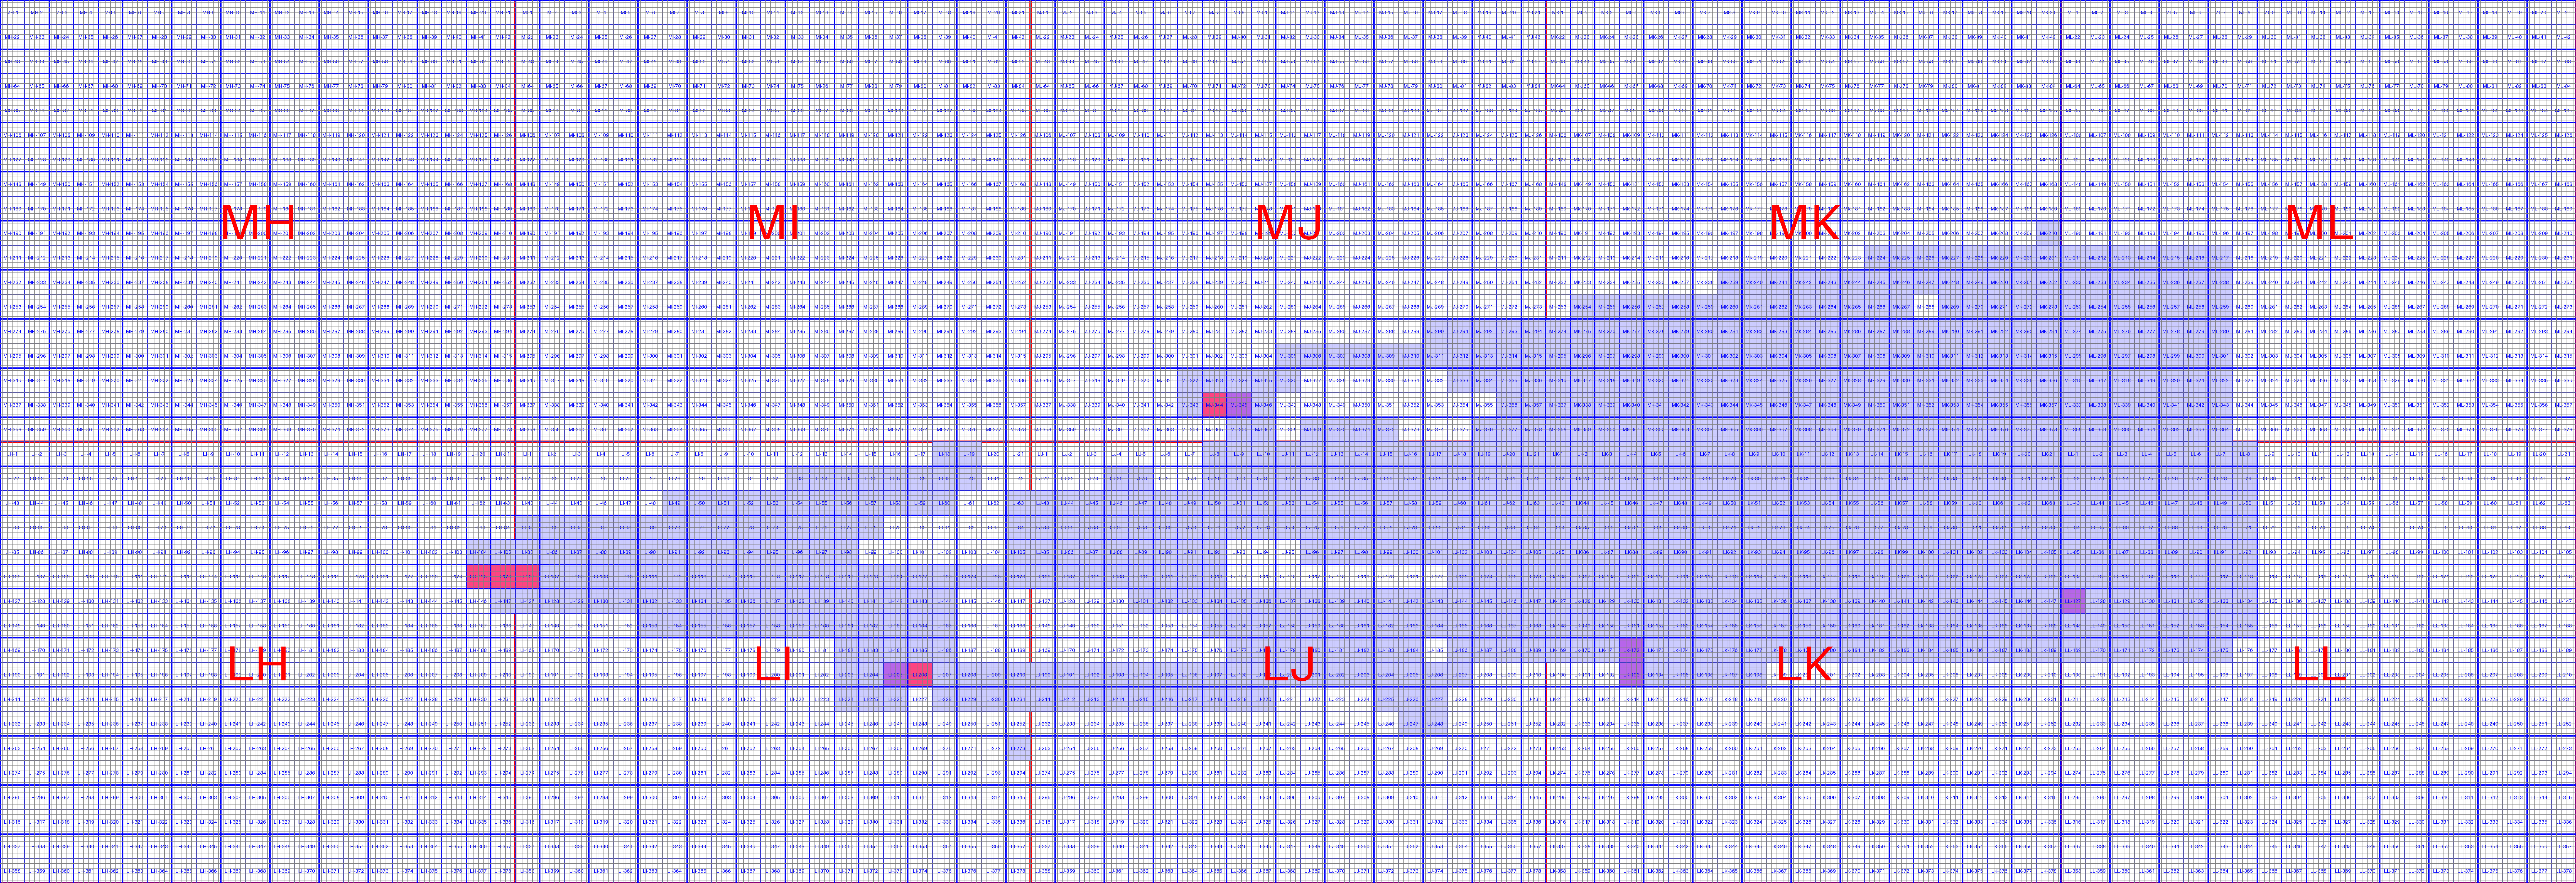

In [20]:
# Make sure we're not doing noisy debugging and create our image!
logger.setLevel(level=logging.INFO)

(img, grid) = plot(
    shadings=shadings,
    base_su=(8,12),              # The SU we should start with in the bottom-left corner (L.H) -> (8,12)
    height_tiles=2, width_tiles=5,     # How many SUs to include in the visual
    subcell_size_px=10,          # How many pixels wide each subcell should be
    su_text=True,
    tile_text=True)
img